## Skill Advisor model using Doc2Vec and K-mean clustering

In [9]:
import glob
import pandas as pd

# Read the cleaned json file generated from wordtovec notebook in dataframe

df = pd.read_json('cleaned_for_embeddings.json', lines=True)

# Get the skills and corresponsing job titiles 
skill_list = df.skill.values.tolist()
job_label = df.job_name.values.tolist()

In [3]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [job_label[i]]) for i, doc in enumerate(skill_list)]


# make doc2vec model,
# dbow_words = 1, dm = 0, see reasoning here:
# https://stackoverflow.com/questions/44011706/what-is-different-between-doc2vec-models-when-the-dbow-words-is-set-to-1-or-0
# try to make document vectors and word vectors more comparable
model1 = Doc2Vec(documents, vector_size=50, window=3, min_count=2, 
                 workers=4, dbow_words=1, dm=0)

In [4]:
# train model
model1.train(documents=documents, total_examples=model1.corpus_count, epochs=50)

In [5]:
# save model
model1.save('doc2vec_kmeans/doc2vec_kmeans')

## PCA and t-SNE conversion

First load up the model if need to

In [1]:
from gensim.models.doc2vec import Doc2Vec
model1 = Doc2Vec.load('doc2vec_kmeans/doc2vec_kmeans')

This part of the code (`tsneconversion` and `cluster_visualization`) is copied over from `wordtovec.ipynb` just to make it easier

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsneconversion(model, word, list_names, labels=['Target', 'Related', 'Comparitive']):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    word_labels = [word]
    color_list  = ['red']
    label_list  = [labels[0]]

    # initialize with the query word vector
    word_vector = model[word]
    arrays = np.array([word_vector])
    
    # gets list of most similar words/skills to target word
    close_words = model.wv.most_similar([word_vector])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.get_vector(wrd_score[0])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        label_list.append(labels[1])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # adds the vector for each of the words from list_names to the array
    # used for comparison in visualization
    for wrd in list_names:
        wrd_vector = model.wv.get_vector(wrd)
        word_labels.append(wrd)
        color_list.append('green')
        label_list.append(labels[2])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'X': [x for x in Y[:, 0]],
                       'Y': [y for y in Y[:, 1]],
                       'skill': word_labels,
                       'color': color_list,
                       'label': label_list})
    
    return (df, Y)

/anaconda3/envs/dataworks-forge/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def cluster_visualization(df, word, Y, x_lim, y_lim, title_fmt='Visualization for {}'):
    """
    Function contains
    df = dataframe contanining t-SNE X and Y value for the relavent scatter plot
    word = name of the job or skill
    Y = The t-SNE coordinates of all datapoints
    x_lim, y_lim = Plot limit
    """
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    for color in df.color.unique():
      df_same_color = df[df.color == color]
      label = df_same_color.label.values[0]
      sns.scatterplot(data=df,
                  x="X",
                  y="Y",
                  marker="x",
                  ax=ax,
                  legend=False,
                  color= color,
                  label=label
                )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         ax.text(df["X"][line],
                 df['Y'][line],
                 '  ' + df["skill"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='small',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(18)

    
    #plt.xlim(Y[:, 0].min()-150, Y[:, 0].max()+500)
    #plt.ylim(Y[:, 1].min()-150, Y[:, 1].max()+200)
    
    if x_lim != 0:
        ax.set_xlim(Y[:, 0].min()-x_lim, Y[:, 0].max()+x_lim)
        ax.set_ylim(Y[:, 1].min()-y_lim, Y[:, 1].max()+y_lim)
    
    ax.set_title(title_fmt.format(word.title()))
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend()
    #fig1.savefig("output.png")

In [10]:
# Get job_title vectors

unique_jobs = set(job_label)
job_vectors = []
for job in unique_jobs:
    job_vectors.append(model1[job])

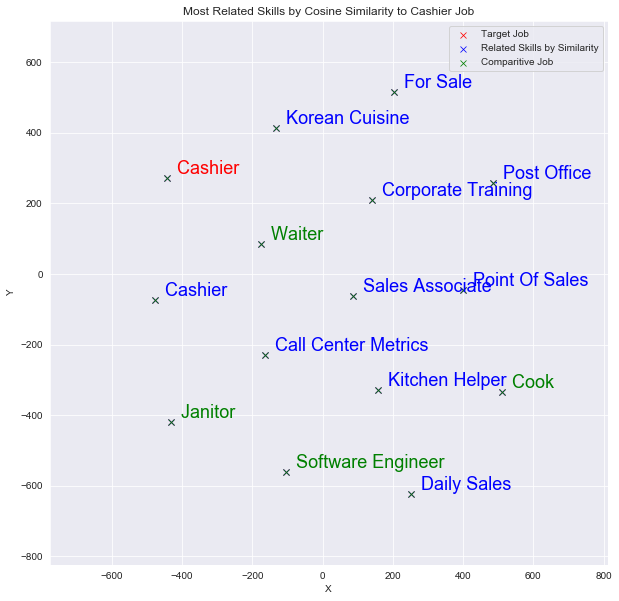

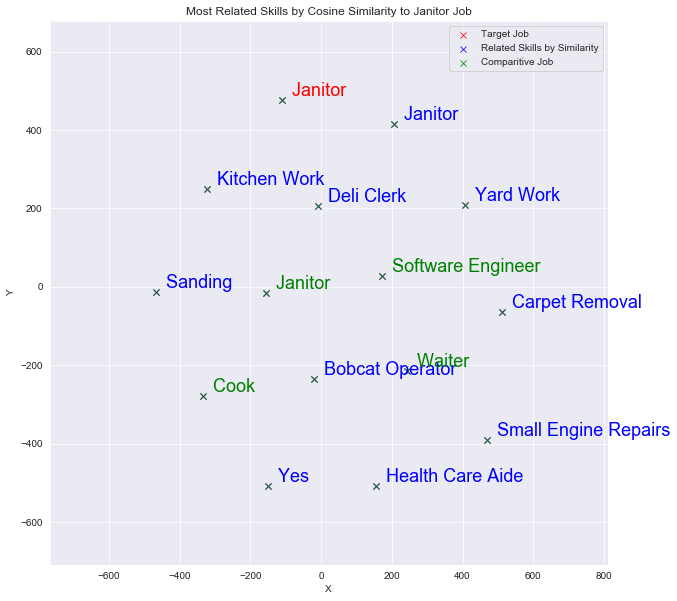

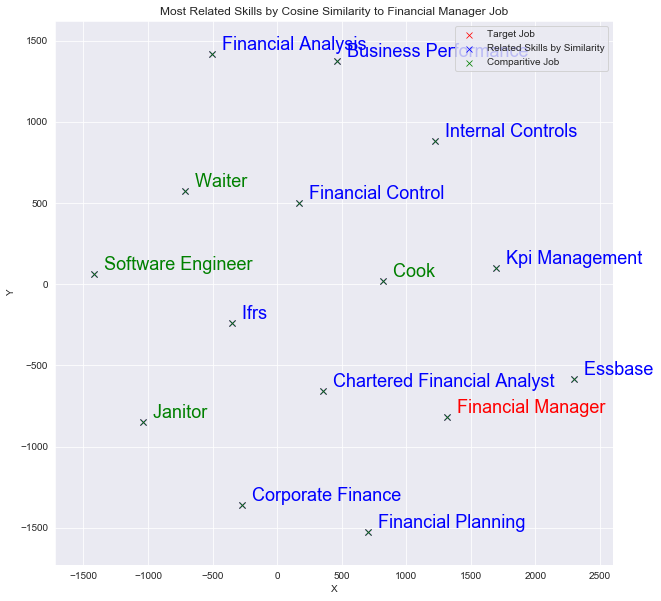

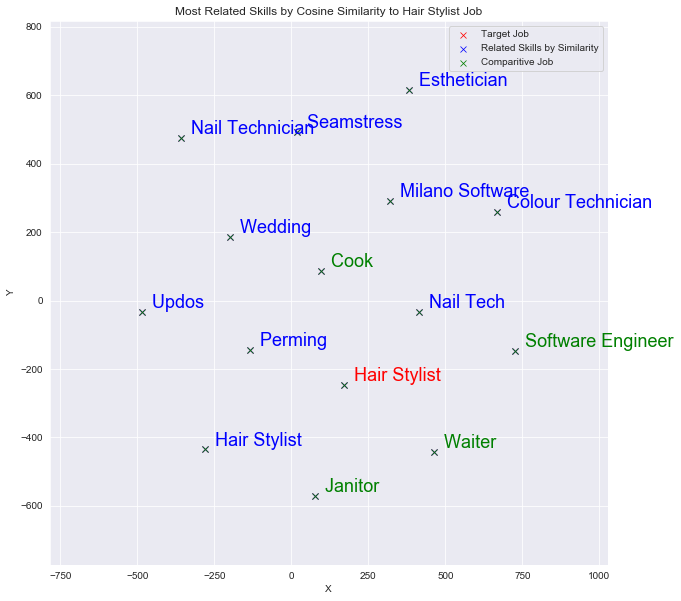

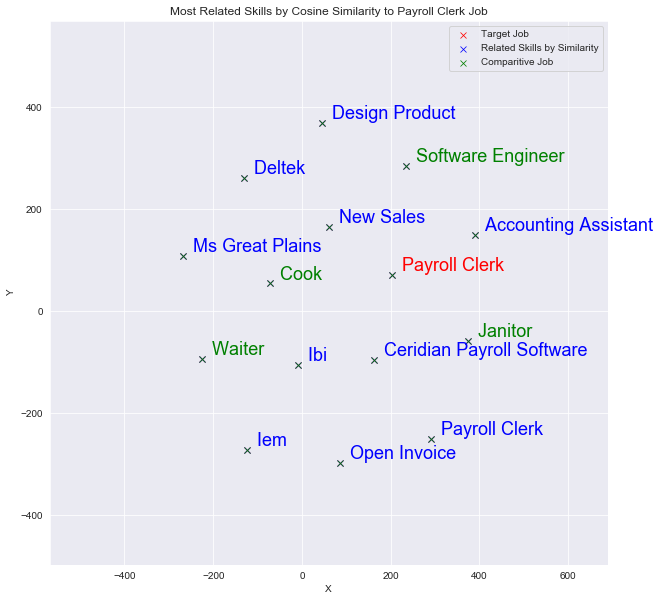

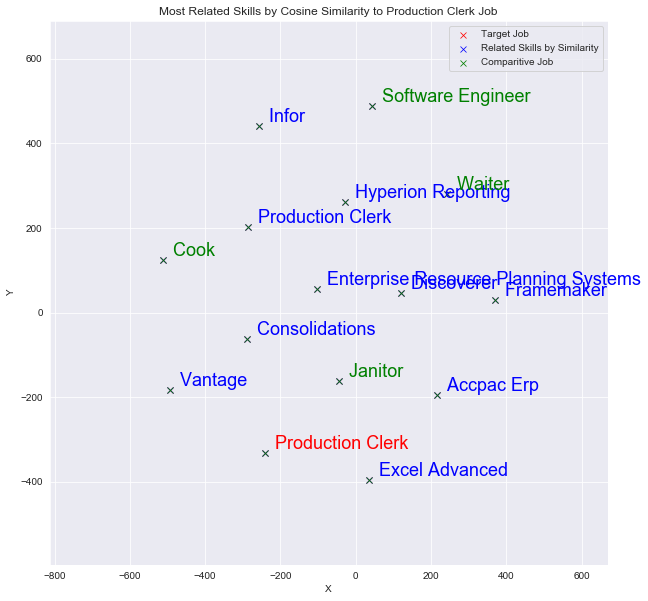

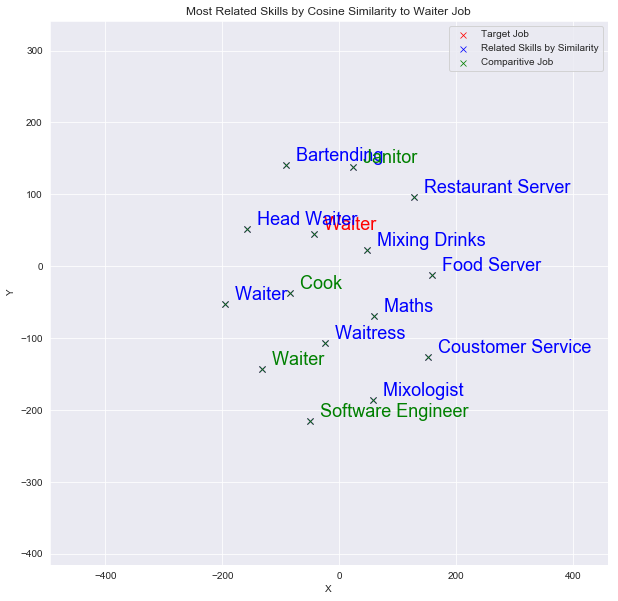

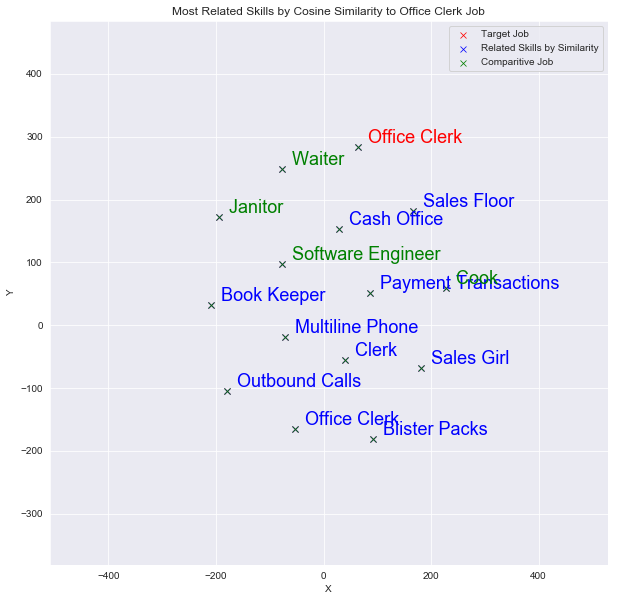

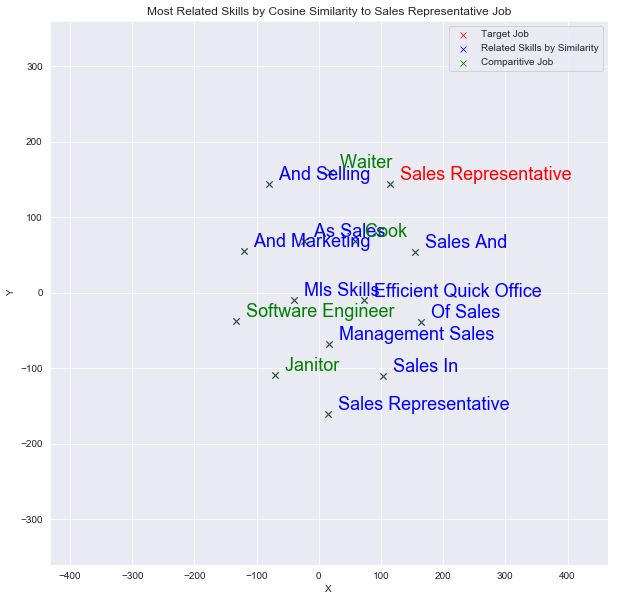

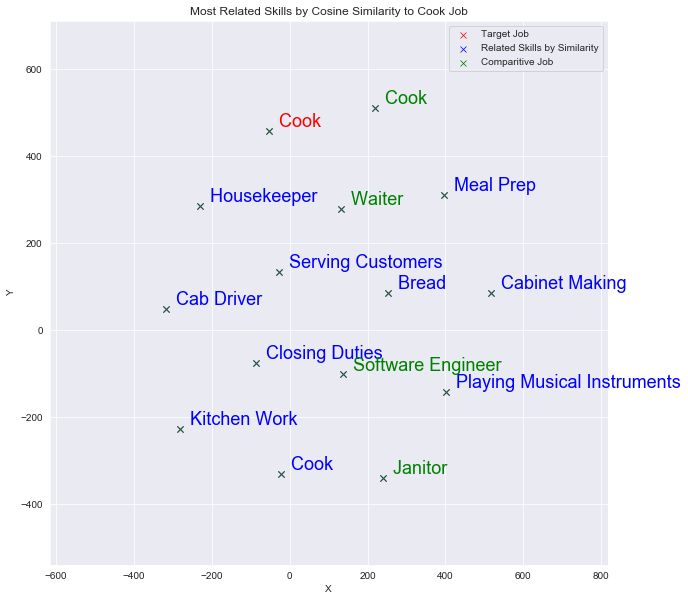

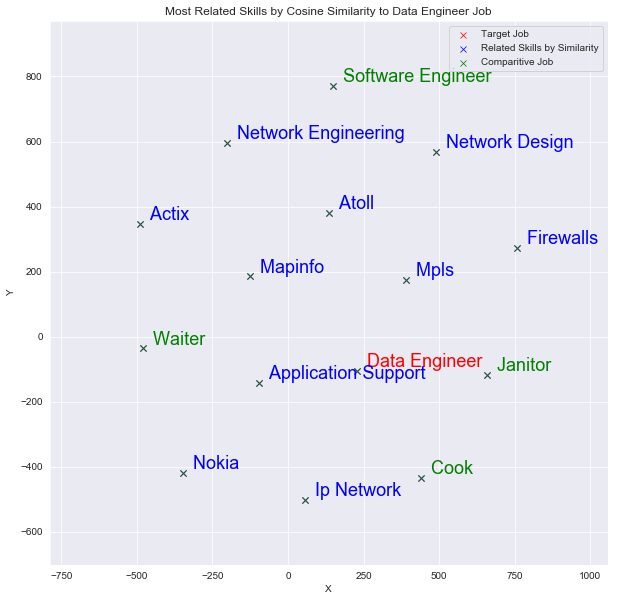

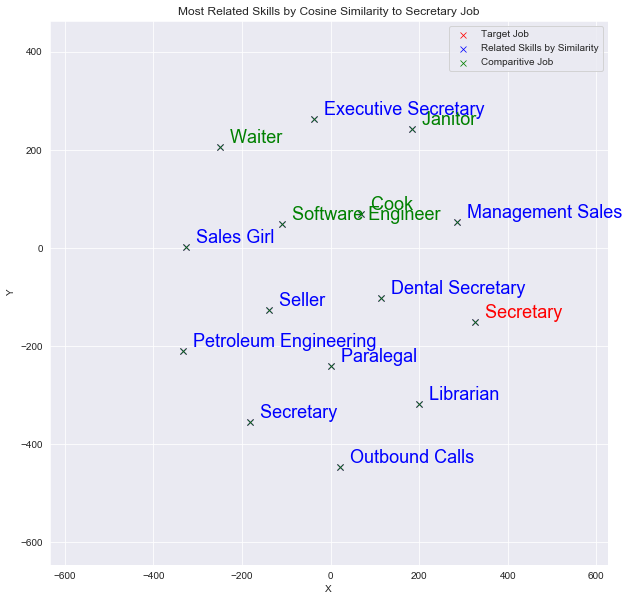

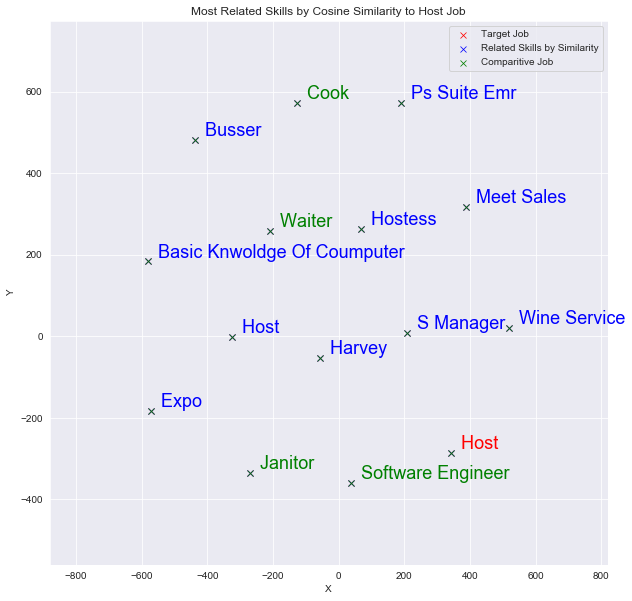

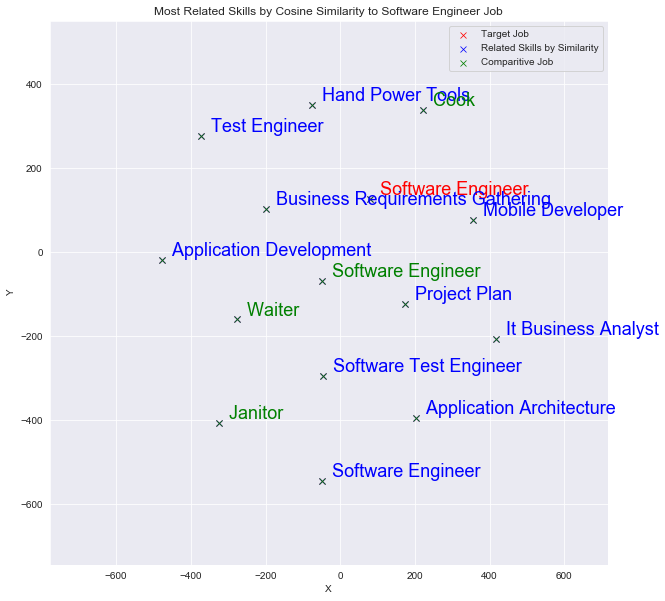

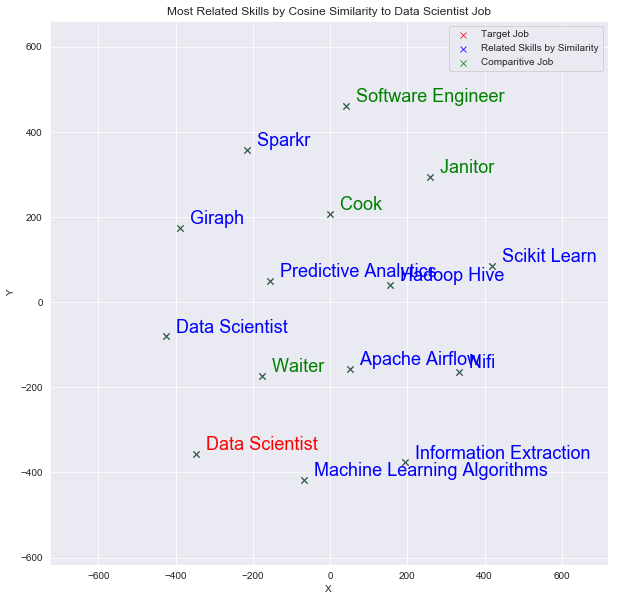

In [29]:
for job in unique_jobs:
  df_tsne, Y = tsneconversion(
    model1,
    job,
    ['cook', 'janitor', 'waiter', 'software engineer'],
    labels=['Target Job', 'Related Skills by Similarity', 'Comparitive Job']
  )
  cluster_visualization(df_tsne, job, Y, 300, 200, title_fmt='Most Related Skills by Cosine Similarity to {} Job')

In [12]:
# Get skill Vectors

skill_vectors = []
for skill in model1.wv.vocab.keys():
    skill_vectors.append(model1.wv[skill])

In [13]:
# Combine all vectors 

import numpy as np

job_vectors = np.array(job_vectors)
skill_vectors = np.array(skill_vectors)
all_vec = np.concatenate((job_vectors, skill_vectors))
skills_and_jobs = list(unique_jobs) + list(model1.wv.vocab.keys())

In [14]:
# Run K-means

import nltk
from nltk.cluster import KMeansClusterer

NUM_CLUSTERS = 15
initial_means = [model1[job] for job in unique_jobs]

kclusterer = KMeansClusterer(
  NUM_CLUSTERS,
  distance=nltk.cluster.util.cosine_distance,
  initial_means=initial_means
)
assigned_clusters = kclusterer.cluster(all_vec, assign_clusters=True)

In [15]:
# For visualization

# Reduces the dimensionality from 300 to 50 dimensions with PCA
#reduc = PCA(n_components=50).fit_transform(all_vec)
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(all_vec)

In [16]:
# Create dataframe with skills and corresponding cluster number and TSNE co-ordinates

df_cluster = pd.DataFrame(
  {
    'skill': skills_and_jobs,
    'cluster': assigned_clusters, 
    'X': Y[:,0],
    'Y': Y[:,1],
    'point': list(all_vec)
  }
)
df_cluster

,skill,cluster,X,Y,point
0,cashier,0,-5.410566,1.788086,"[1.2929016, 0.008560056, -0.27753648, -0.48399..."
1,janitor,0,-16.155294,53.523212,"[0.28618696, 0.12215998, 0.35839704, -0.246170..."
2,financial manager,2,30.203304,-49.767567,"[0.38289768, -0.0091811, 1.2981336, -0.0876219..."
3,hair stylist,0,-30.489460,65.701965,"[0.26326275, 0.12126335, -0.5524388, -0.933989..."
4,payroll clerk,5,0.950557,-2.298649,"[0.38524735, -0.05488952, 0.09910063, 0.198963..."
5,production clerk,5,21.893353,-29.551117,"[0.7577158, -0.1508395, 0.45578367, 0.13486736..."
6,waiter,0,-32.445190,38.331230,"[0.63355523, 0.06110955, -0.013662121, 0.27610..."
7,office clerk,11,-6.797702,-5.188555,"[0.36285922, 0.47613168, -0.119971536, -0.2703..."
8,sales representative,8,6.584216,2.319024,"[0.2522664, 0.07225798, -0.32380483, -0.865629..."
9,cook,0,-27.847532,53.594440,"[0.091790386, -0.3004608, -0.628173, -1.361504..."


In [17]:
job_clusters = df_cluster.loc[:14]
# see clusters for jobs
job_clusters

,skill,cluster,X,Y,point
0,cashier,0,-5.410566,1.788086,"[1.2929016, 0.008560056, -0.27753648, -0.48399..."
1,janitor,0,-16.155294,53.523212,"[0.28618696, 0.12215998, 0.35839704, -0.246170..."
2,financial manager,2,30.203304,-49.767567,"[0.38289768, -0.0091811, 1.2981336, -0.0876219..."
3,hair stylist,0,-30.489460,65.701965,"[0.26326275, 0.12126335, -0.5524388, -0.933989..."
4,payroll clerk,5,0.950557,-2.298649,"[0.38524735, -0.05488952, 0.09910063, 0.198963..."
5,production clerk,5,21.893353,-29.551117,"[0.7577158, -0.1508395, 0.45578367, 0.13486736..."
6,waiter,0,-32.445190,38.331230,"[0.63355523, 0.06110955, -0.013662121, 0.27610..."
7,office clerk,11,-6.797702,-5.188555,"[0.36285922, 0.47613168, -0.119971536, -0.2703..."
8,sales representative,8,6.584216,2.319024,"[0.2522664, 0.07225798, -0.32380483, -0.865629..."
9,cook,0,-27.847532,53.594440,"[0.091790386, -0.3004608, -0.628173, -1.361504..."


In [18]:
from nltk.cluster.util import cosine_distance

def get_closest(df_cluster, point, topn=11):
  closeness = df_cluster.copy()
  closeness['distance'] = closeness['point'].apply(lambda p: cosine_distance(p, point))
  closeness = closeness.sort_values('distance')
  return closeness.head(topn)

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances

score = silhouette_score(df_cluster.point.tolist(), df_cluster.cluster.tolist(), metric='cosine')
'Silhoutte score is %f' % score

'Silhoutte score is 0.128839'

In [21]:
df_cluster

,skill,cluster,X,Y,point
0,cashier,0,-5.410566,1.788086,"[1.2929016, 0.008560056, -0.27753648, -0.48399..."
1,janitor,0,-16.155294,53.523212,"[0.28618696, 0.12215998, 0.35839704, -0.246170..."
2,financial manager,2,30.203304,-49.767567,"[0.38289768, -0.0091811, 1.2981336, -0.0876219..."
3,hair stylist,0,-30.489460,65.701965,"[0.26326275, 0.12126335, -0.5524388, -0.933989..."
4,payroll clerk,5,0.950557,-2.298649,"[0.38524735, -0.05488952, 0.09910063, 0.198963..."
5,production clerk,5,21.893353,-29.551117,"[0.7577158, -0.1508395, 0.45578367, 0.13486736..."
6,waiter,0,-32.445190,38.331230,"[0.63355523, 0.06110955, -0.013662121, 0.27610..."
7,office clerk,11,-6.797702,-5.188555,"[0.36285922, 0.47613168, -0.119971536, -0.2703..."
8,sales representative,8,6.584216,2.319024,"[0.2522664, 0.07225798, -0.32380483, -0.865629..."
9,cook,0,-27.847532,53.594440,"[0.091790386, -0.3004608, -0.628173, -1.361504..."


/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


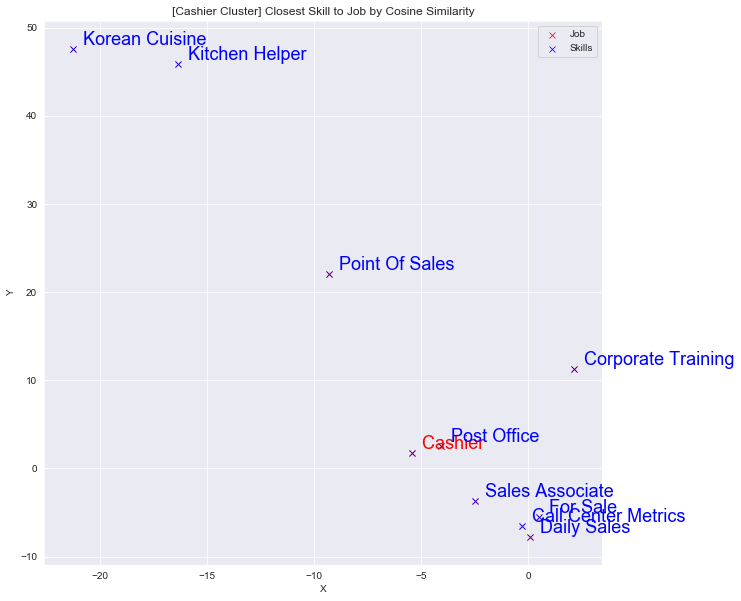

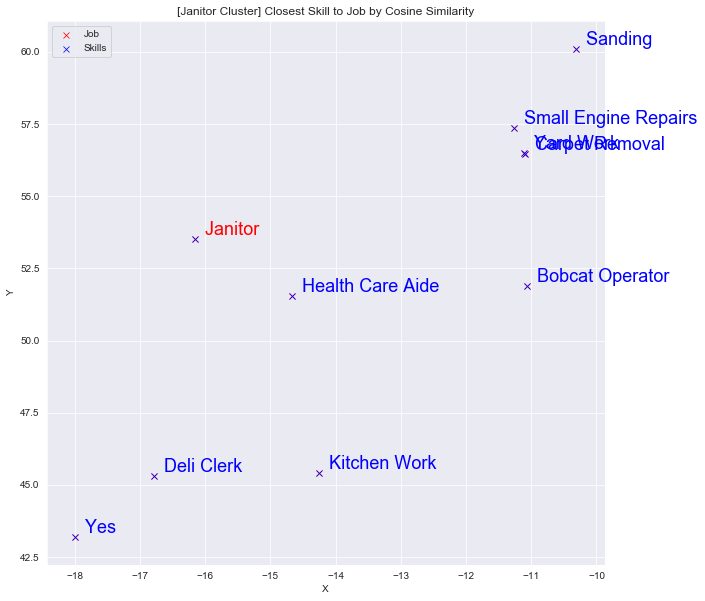

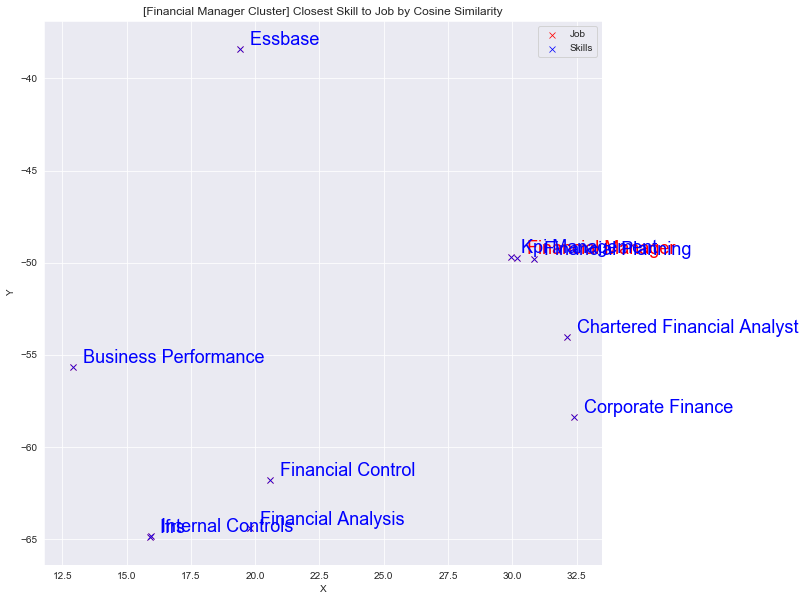

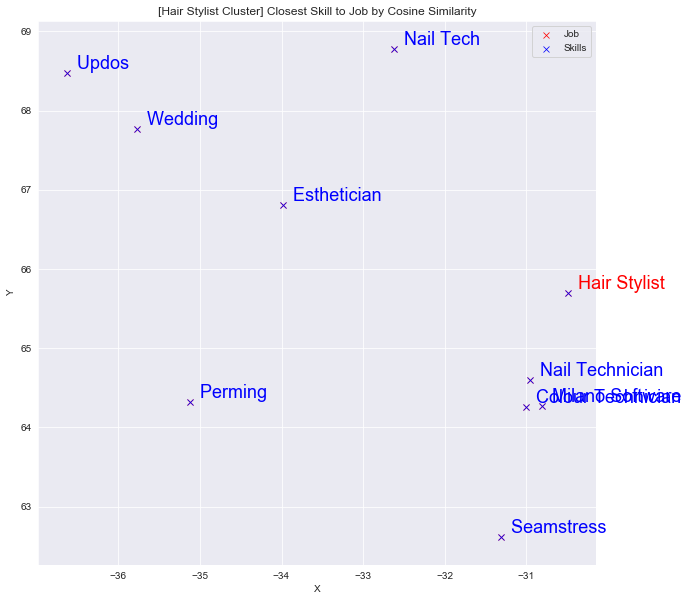

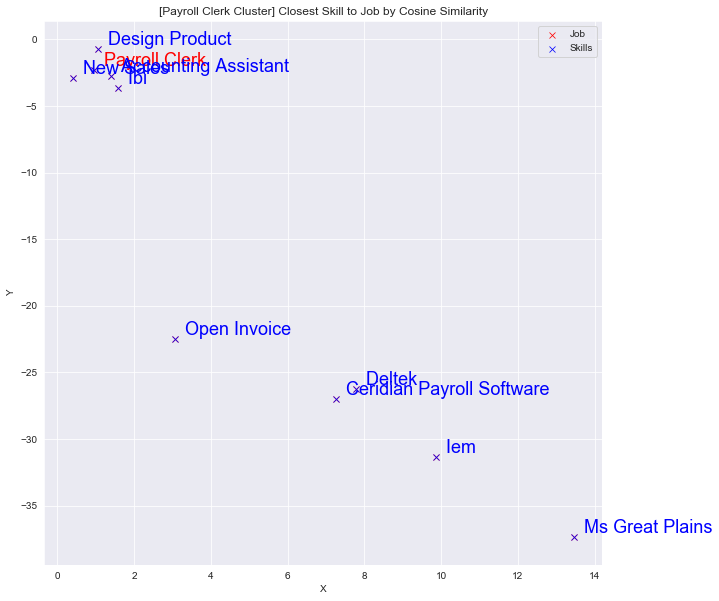

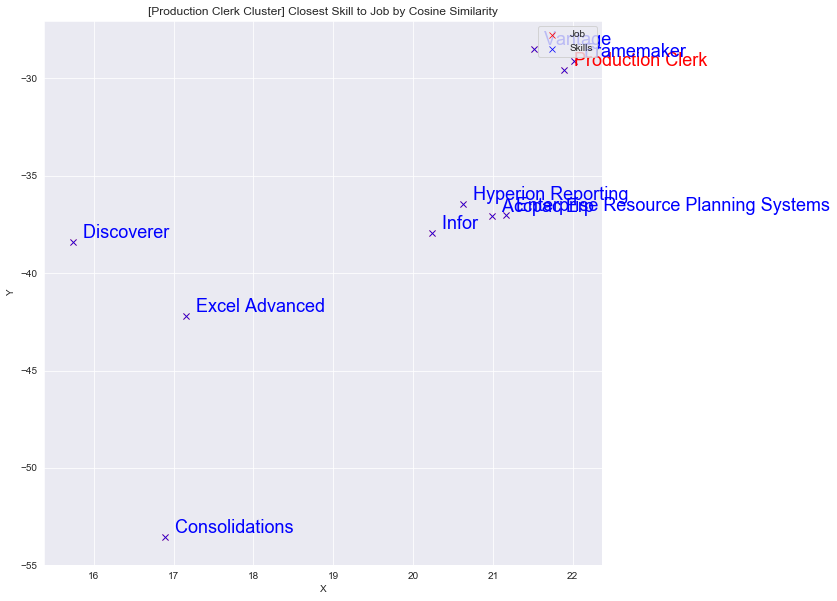

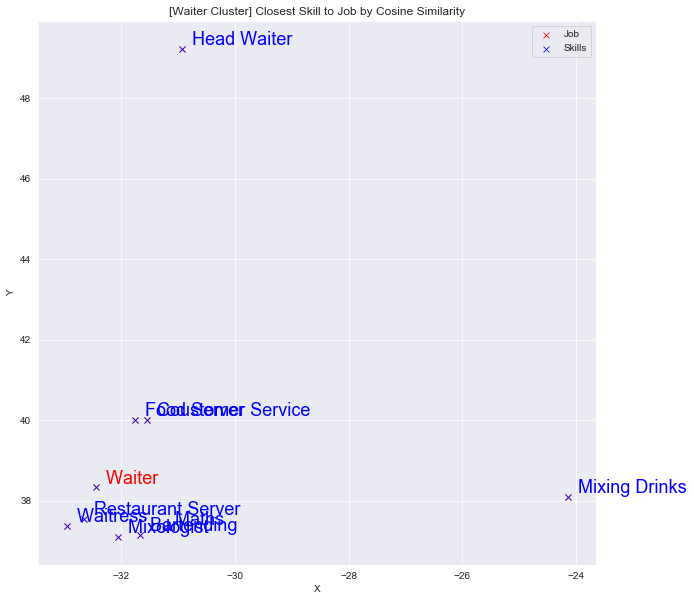

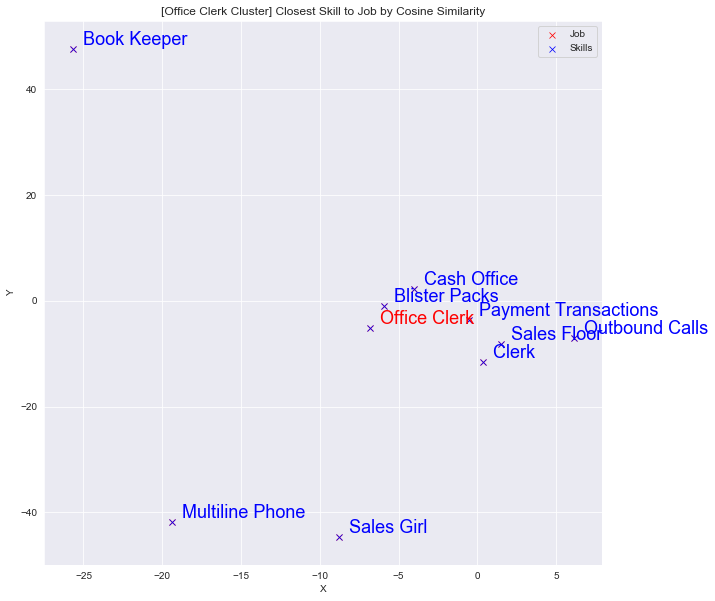

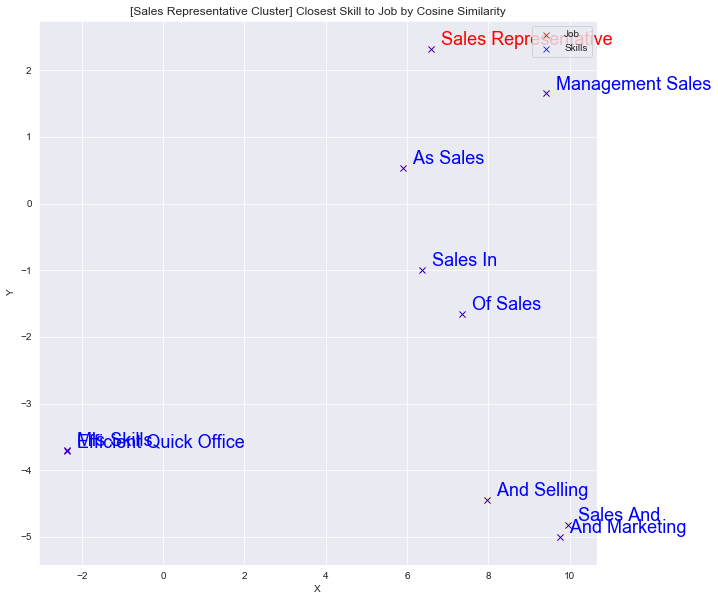

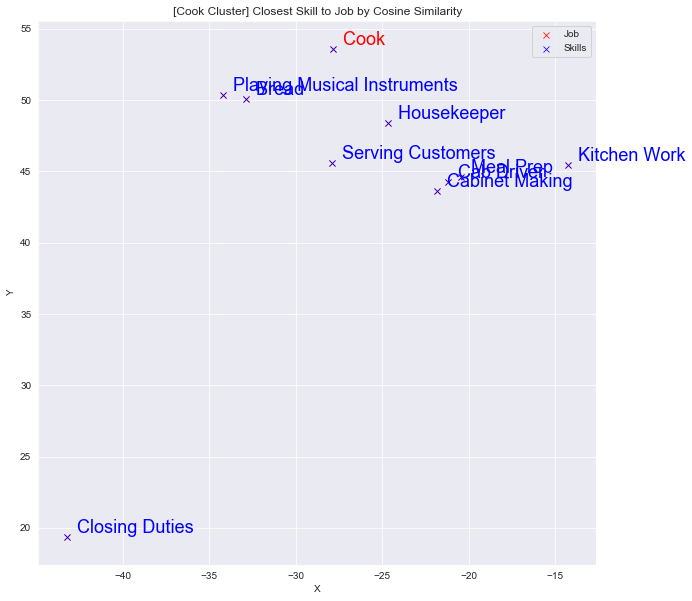

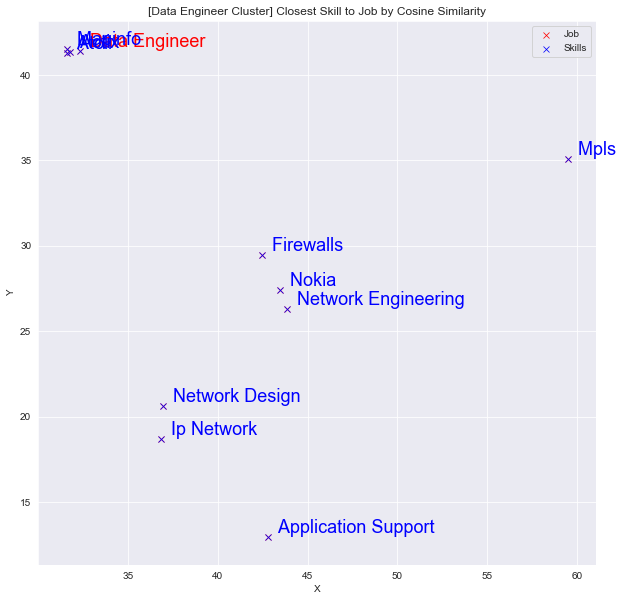

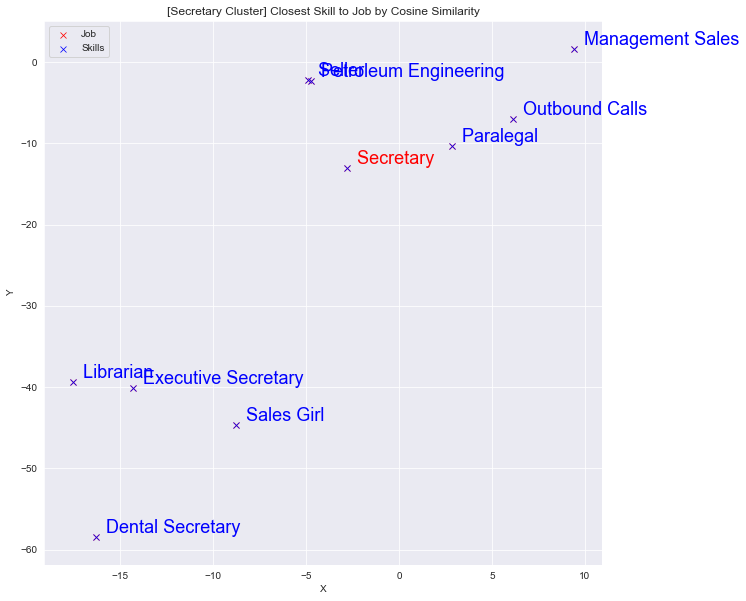

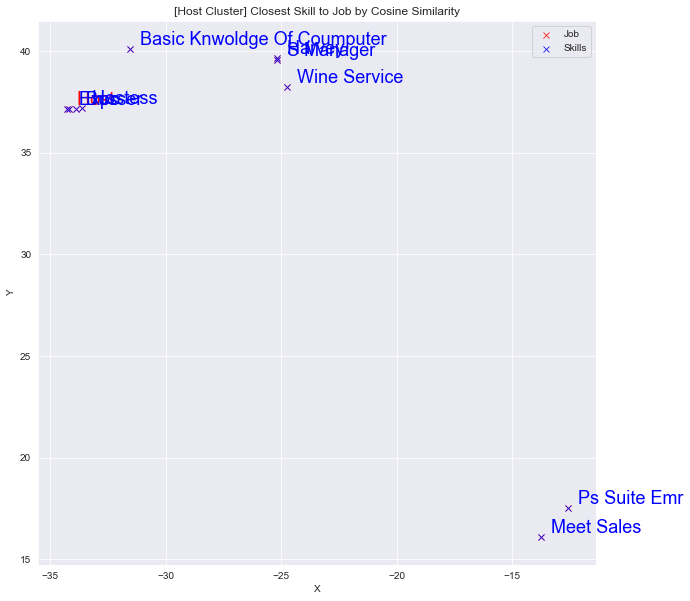

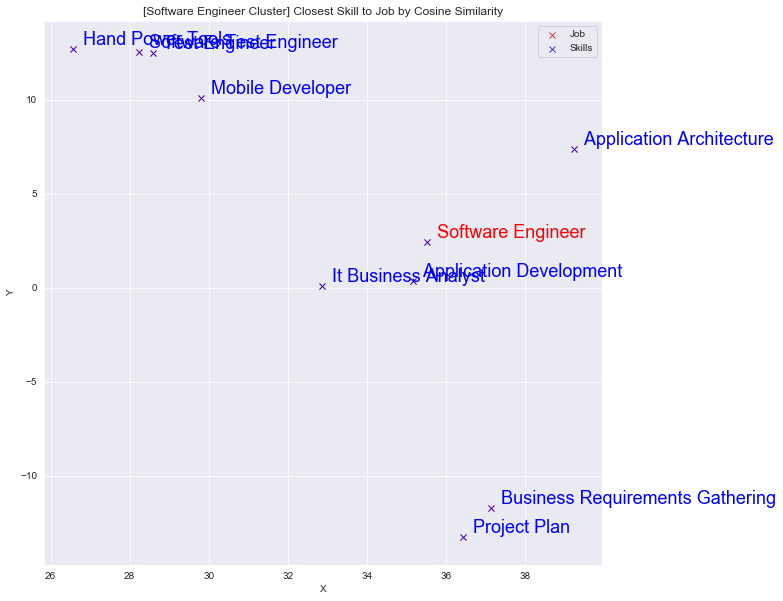

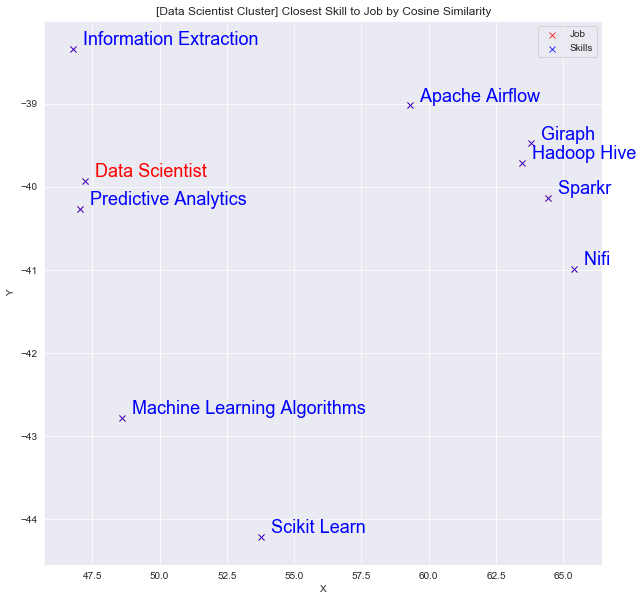

In [27]:
## Plot the cluster of plots with closest skill in the vector space
for idx in range(NUM_CLUSTERS):
  job = df_cluster.loc[[idx]]
  job.loc[:,"color"] = "red"
  cluster_number = job.cluster.values[0]
  df_job_cluster = df_cluster[df_cluster.cluster == cluster_number]

  N_sample = 10
  color = ["blue"] * N_sample
  df_plot = get_closest(df_cluster, job.point.values[0], topn=N_sample + 1)
  job_name = job.skill.values[0]
  df_plot = df_plot[df_plot.skill != job_name]
  df_plot["color"] = color[:len(df_plot)]
  df_final_plot = pd.concat([job, df_plot])
  labels = ['Job'] + (['Skills'] * len(df_plot))
  df_final_plot['label'] = labels
  df_final_plot = df_final_plot.reset_index(drop=True)

  cluster_visualization(df_final_plot, job_name, Y, 0, 0, title_fmt='[{} Cluster] Closest Skill to Job by Cosine Similarity')